#Data Analysis Using Youtube Video Data from Valorant Channels that i'm used to watch

#1. Introduction and Objectives


##1.1 Introduction

My name is Victor and this is my first project in data analysis, I wanted to do this project because it looks quite simple and different. When I was looking for projects on youtube I saw this idea on Thu Vu channel (the link is here: [Thu Vu data analytics](https://www.youtube.com/@Thuvu5)) and it gave me inspiration to try this by myself.
In my free time I really like to watch and play valorant so I came up with this idea and it matched really well.



##1.2 Objectives 

In this project, I tried to:

* Learn how to work with data from an API
* Identify patterns on data and explain why this happen
  * More tags equals more views?
  * Vide duration have impact on views?
  * The likes and comments impacts on views?
  * etc.

##1.3 Dataset
I created my own dataset using the Google Youtube Data API version 3.0.

##Ethics of data source
Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there is no particular privacy issues. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.

This is the lib to connect with the api client

In [102]:
pip install --upgrade google-api-python-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This is the lib to fix one of the data collumn

In [103]:
pip install isodate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
# Basic imports
from googleapiclient.discovery import build #Connect API
import pandas as pd #Data Manipulation
from dateutil import parser #Data formatting
import isodate #Data formatting

#Datavisualization packages
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns 
sns.set(style="darkgrid", color_codes=True)

##2. Data creation with Youtube API
I first created a project on Google Developers Console, then requested an authorization credential (API key). Afterwards, I enabled Youtube API for my application, so that I can send API requests to Youtube API services. Then, I went on Youtube and checked the channel ID of each of the channels that I would like to include in my research scope (using this method: https://www.youtube.com/watch?v=0oDy2sWPF38). Then I created the functions for getting the channel statistics via the API.

In [105]:
api_service_name = "youtube" 
api_version = "v3"
api_key="API_KEY_HERE" #You can take your own API Key on youtube documentation

channels_ids = ["UCWphjEePrzIrRA5mwcOt_4Q", #Grimm Channel
                "UC54ubmq5wHM3fK0ERA856Zg", #Aspas Channel
                "UC9Qx5N_X7p2nTwPfoKXPQeA", #Sacy Channel
                "UCEmEYjCSFNYh-ml_o2mn71Q", #Otsuka Channel
                "UCXwNOkzewUAcBTM0Sg4iiqw", #Jollz Channel
                "UCckPYr9b_iVucz8ID1Q67sw", #Tenz Channel
                "UChq2oJ0Y4EecbIkcZtMACsA", #FRTT Channel
                "UCRm3UqpwcxDmoPT9PKn4qPw", #TCK10 Channel
                "UCABUGfcFJhffRFZxSl-mIiw", #Sinatra Channel
                "UCmxbPURszE7ojc6Bs_5pBEQ" #schrodingerLee Channel
                ]
#setup the api
youtube = build(api_service_name,api_version,developerKey=api_key)

In [106]:
#Function to get data from the channel
def get_channel_data(youtube,channels_ids):
  all_data = []
  #Here's a request to api to take from channels() info ~> check documentation its really easy
  request = youtube.channels().list(
      part="snippet,contentDetails,statistics",
      id = ','.join(channels_ids) #To work with multiple channels we need to do this
  )
  response = request.execute() # Execute the request
  for item in response["items"]: #Storage data from the request
    data = {'channel_name': item["snippet"]["title"], 
            'n°_subscribers' : item["statistics"]["subscriberCount"],
            'n°_views' : item["statistics"]["viewCount"],
            'n°_videos': item["statistics"]["videoCount"],
            'plailyst_id': item["contentDetails"]["relatedPlaylists"]["uploads"] #The playlist ID connects all the videos from the channel
    }
    all_data.append(data)
  return pd.DataFrame(all_data)

#This Function get all the videos from a channel
def get_playlist_data(youtube,plailyst_id):

  video_ids = []

  for  id in plailyst_id: #here we need to take one plailist_id at a time
    request = youtube.playlistItems().list( #The request this time is on playlistItems
          part="snippet,contentDetails",
          playlistId=str(id),
          maxResults = 50 #When generated a page of videos contain only 5 by default
          #So we generate a page with 50 videos
      )
    response = request.execute()
    for item in response["items"]:
      video_ids.append(item["contentDetails"]["videoId"])
    next_page_token = response.get("nextPageToken") #Once we get all the videos from the current page we need to run the loop on the next page
    while next_page_token is not None: #The loop will end when the page is empty and doesn't have more videos to take
      request = youtube.playlistItems().list(
          part="snippet,contentDetails",
          playlistId=str(id),
          maxResults = 50,
          pageToken = next_page_token
      )
      response = request.execute()
      for item in response["items"]:
        video_ids.append(item["contentDetails"]["videoId"])
      next_page_token = response.get("nextPageToken")
  return video_ids

#This function get all details from a video
def get_video_details(youtube,video_ids):
  all_video = []
  for  i in range(0,len(video_ids),50):
    request = youtube.videos().list( #Resquest video info
        part="snippet,contentDetails,statistics",
        id = ','.join(video_ids[i:i+50]) #We create this mini batch to request the videos
    )
    response = request.execute()
    for video in response["items"]:
      stats = {'snippet': ["channelTitle","title","description","tags","publishedAt"],
              'statistics': ["viewCount","likeCount","favoriteCount","commentCount"],
              'contentDetails': ["duration"]
      }
      video_info={}
      video_info["video_id"] = video["id"]
      for k in stats.keys():
        for v in stats[k]:
          try:
            video_info[v] = video[k][v]
          except:
            video_info[v] = None

      all_video.append(video_info)
  return pd.DataFrame(all_video)

#3. Get statistics

Using the `get_channel_stats` function, now we are going to obtain the channel statistics for all the 10 channels in scope.

In [107]:
df = get_channel_data(youtube,channels_ids)

Let's see the output, we already have the total number of subscribers, views and videos from each channel. In addition we have the `playlist_id` to connect with the videos

In [108]:
df

,channel_name,n°_subscribers,n°_views,n°_videos,plailyst_id
0,Sinatraa,473000,95062771,517,UUABUGfcFJhffRFZxSl-mIiw
1,ASPAS,190000,18976781,201,UU54ubmq5wHM3fK0ERA856Zg
2,schrodingerLee,1370000,448280819,337,UUmxbPURszE7ojc6Bs_5pBEQ
3,Sacy,139000,16282537,405,UU9Qx5N_X7p2nTwPfoKXPQeA
4,TcK 10,60600,6685820,196,UURm3UqpwcxDmoPT9PKn4qPw
5,Jollztv,391000,94269858,1201,UUXwNOkzewUAcBTM0Sg4iiqw
6,TenZ,1710000,171677568,272,UUckPYr9b_iVucz8ID1Q67sw
7,FRTTT,221000,30656842,416,UUhq2oJ0Y4EecbIkcZtMACsA
8,OtsukaXD,106000,15125338,278,UUEmEYjCSFNYh-ml_o2mn71Q
9,Grim,934000,114692371,234,UUWphjEePrzIrRA5mwcOt_4Q


We already have data to play, but first we need to convert this to numeric

In [109]:
numeric_cols = ["n°_subscribers", "n°_views", "n°_videos"]
print("Before Transformation")
print(df.dtypes)
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
print("\n---------------------\n")
print("After Transformation")
print(df.dtypes)

Before Transformation
channel_name      object
n°_subscribers    object
n°_views          object
n°_videos         object
plailyst_id       object
dtype: object

---------------------

After Transformation
channel_name      object
n°_subscribers     int64
n°_views           int64
n°_videos          int64
plailyst_id       object
dtype: object


Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

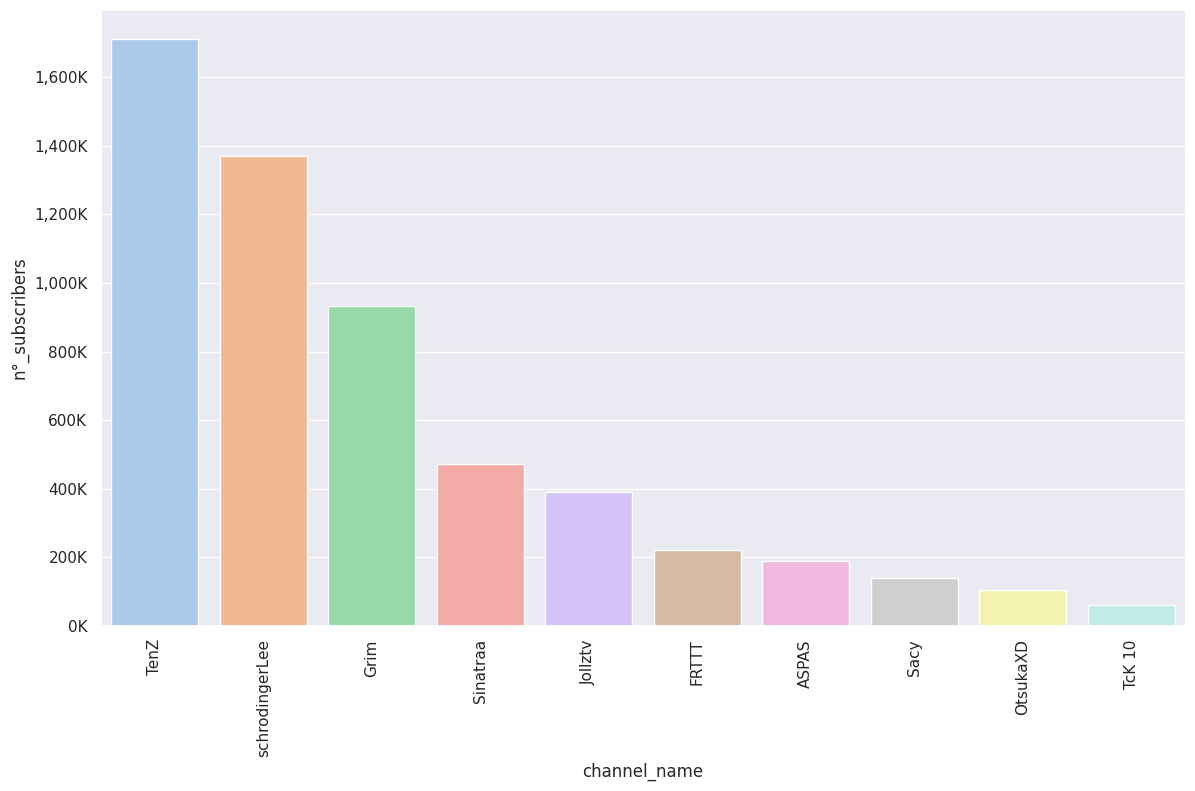

In [110]:
ax = sns.barplot(x="channel_name", y="n°_subscribers", data = df.sort_values("n°_subscribers", ascending=False), palette = 'pastel') #Pastel is a sweet color
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Next, we will look at the rank considering the total number of views of the channels. The rank is fairly similar to the subscriber count rank, excluding the 1st and 2nd place. This rank really surprised me because i was not expecting this big difference in `n°_views`
 * I think this happens because schrodingerLee invest a lot in youtube "shorts" and these videos are more easy to get viral (more thoughts are explored ahead)
 * One thing that is not explicit but we can see on this graph is that Brazilian channels (FRTT, ASPAS, Sacy, Otsuka and TCK 10) have way less subscribers/views than English channels (Tenz, schrodingerLee, Grim, Sinatra and Jollztv). This may ocurr because there are more English speakers (as native or second language) than Portuguese speakers.

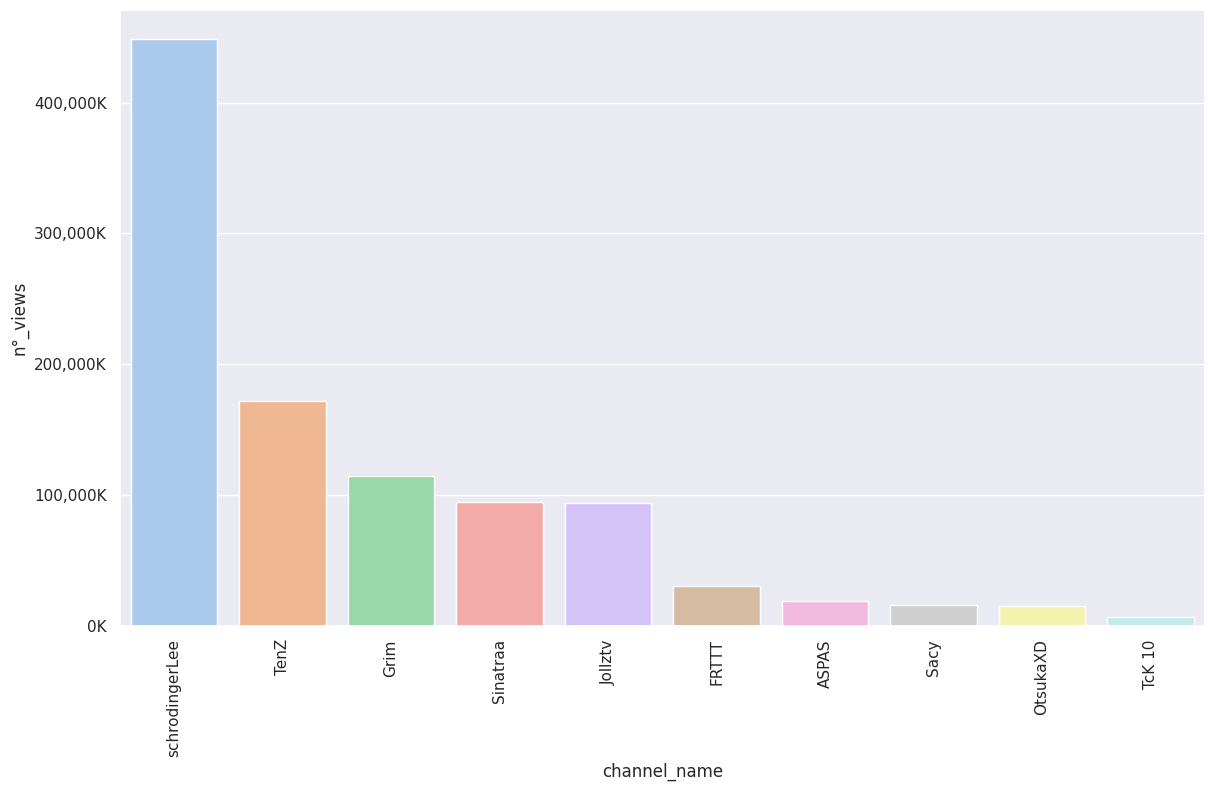

In [111]:
ax = sns.barplot(x="channel_name", y="n°_views", data = df.sort_values("n°_views", ascending=False), palette = 'pastel')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [112]:
video_ids = get_playlist_data(youtube,list(df["plailyst_id"])) #Get all videosIDs

In [113]:
video_df = get_video_details(youtube,video_ids) #Connects VideoId with the information

In [114]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration
0,amEs897wdgo,Sinatraa,CARRYING SUBROZA IN RADIANT RANKED.. (VALORANT),🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-21T19:40:47Z,14110,979,0,0,PT10M6S
1,qDMxgarno0Q,Sinatraa,SINATRAA REACTS TO SENTINELS VS FURIA (VALORAN...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-20T05:53:34Z,84465,2564,0,71,PT32M7S
2,pKNiBgFVzQc,Sinatraa,SINATRAA CARRIES PROD In RADIANT RANKED (VALOR...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-12T02:40:22Z,116069,3856,0,91,PT8M48S
3,2hl9w63p_Hk,Sinatraa,SINATRAA DOMINATING COMPETITIVE VALORANT!?!? P...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-11T03:18:46Z,114178,4063,0,107,PT8M3S
4,PT6n3C2TW3o,Sinatraa,SINATRAA RETURNS TO UNTAMEABLE BEASTS ?! PREMI...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-10T02:02:03Z,156789,5820,0,126,PT15M46S
...,...,...,...,...,...,...,...,...,...,...,...
4055,smaItNJXpSE,Grim,How I became the most AGGRESSIVE SAGE main on ...,I have finally become the best aggressive sage...,"[valorant, valorant moments, valorant montage,...",2020-10-17T20:42:59Z,215567,12487,0,493,PT3M51S
4056,YuJUvtpR9Bg,Grim,How I made SAGE an Aggressive DUELIST on Valorant,I managed to turn sage into a duelist and beco...,"[valorant, valorant moments, valorant montage,...",2020-09-27T16:50:03Z,388978,20093,0,651,PT3M51S
4057,YzZaWRGkoKg,Grim,Aggressive RAZE plays in Diamond Rank on Valorant,thanks kiwiddle for the title :)\nsong: I WISH...,None,2020-09-03T20:02:48Z,83122,3345,0,92,PT2M23S
4058,Q8ZyTyQc910,Grim,Movement Like Velvet - Raze Montage,Song: EGOVERT - VELVET!\nI'm gonna keep rollin...,None,2020-08-17T21:26:47Z,26987,1386,0,22,PT1M41S


(Preprocessing Data) is needed to work with this data. So we are going to fix the duration time using this isodate lib

In [115]:
video_df ['durationSecs'] = video_df ['duration'].apply(lambda x: isodate.parse_duration(x))
video_df ['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

It looks better right?

In [116]:
video_df[["durationSecs",'duration']]

,durationSecs,duration
0,606.0,PT10M6S
1,1927.0,PT32M7S
2,528.0,PT8M48S
3,483.0,PT8M3S
4,946.0,PT15M46S
...,...,...
4055,231.0,PT3M51S
4056,231.0,PT3M51S
4057,143.0,PT2M23S
4058,101.0,PT1M41S


We need to transform this data in real numeric data, so we can work

In [117]:
numeric_cols = ["viewCount", "likeCount", "favoriteCount", "commentCount"]
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = "coerce", axis =1) #the errors are going to be NaN
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount        float64
likeCount        float64
favoriteCount    float64
commentCount     float64
duration          object
durationSecs     float64
dtype: object

Here we are going to remove the youtube shorts so we can plot a graph without them

In [118]:
video_df_no_shorts = video_df[video_df["durationSecs"]> 60].reset_index() #YT shorts can't handle more than 60 seconds

In [119]:
df_graph_no_shorts = video_df_no_shorts.groupby('channelTitle')['viewCount'].sum().reset_index()

In [120]:
df_graph_no_shorts

,channelTitle,viewCount
0,ASPAS,18410767.0
1,FRTTT,30520620.0
2,Grim,114713321.0
3,Jollztv,52786889.0
4,OtsukaXD,14421118.0
5,Sacy,16312948.0
6,Sinatraa,66391680.0
7,TcK 10,6687335.0
8,TenZ,171806043.0
9,schrodingerLee,31265216.0


As I expected schorodingerLee have lost rank, but wow I didn't expected that much. He went from 1st place to 5th place, the rest of the rank just basically stayed as it was. 
* This gave us important information: YT Shorts gives the channel a lot of views, which has a big impact on subscriptions. As we can see, SchrodingerLee (without Shorts) is 5th in the rank with more views but remains 2nd place in number of subscriptions.
* If I were to hype my YT Channel I would probably use the YT shorts, because it would increase my subscribes and, thereafter, it would increase my average views per video. Since the video would be delivered to all the subscribers and not only recommended.

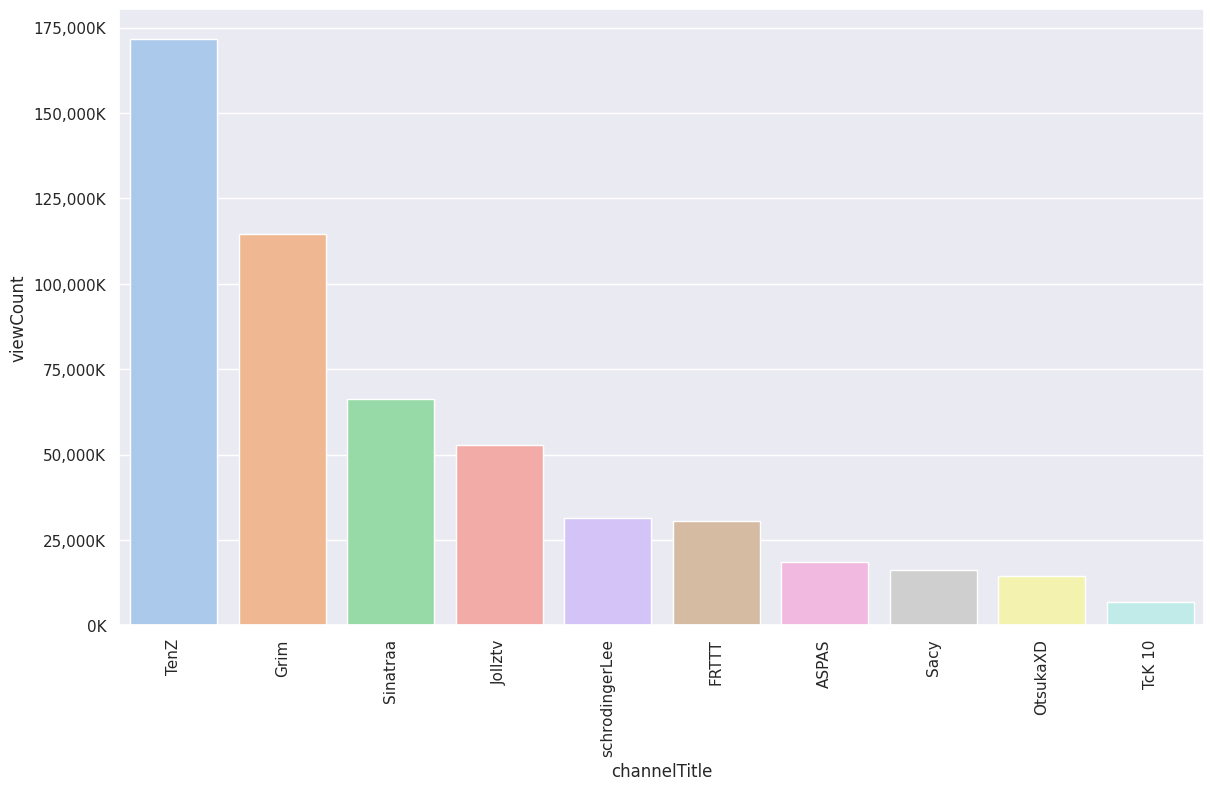

In [121]:
#Views without shorts
ax = sns.barplot(x="channelTitle", y="viewCount", data = df_graph_no_shorts.sort_values("viewCount", ascending=False), palette = 'pastel')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

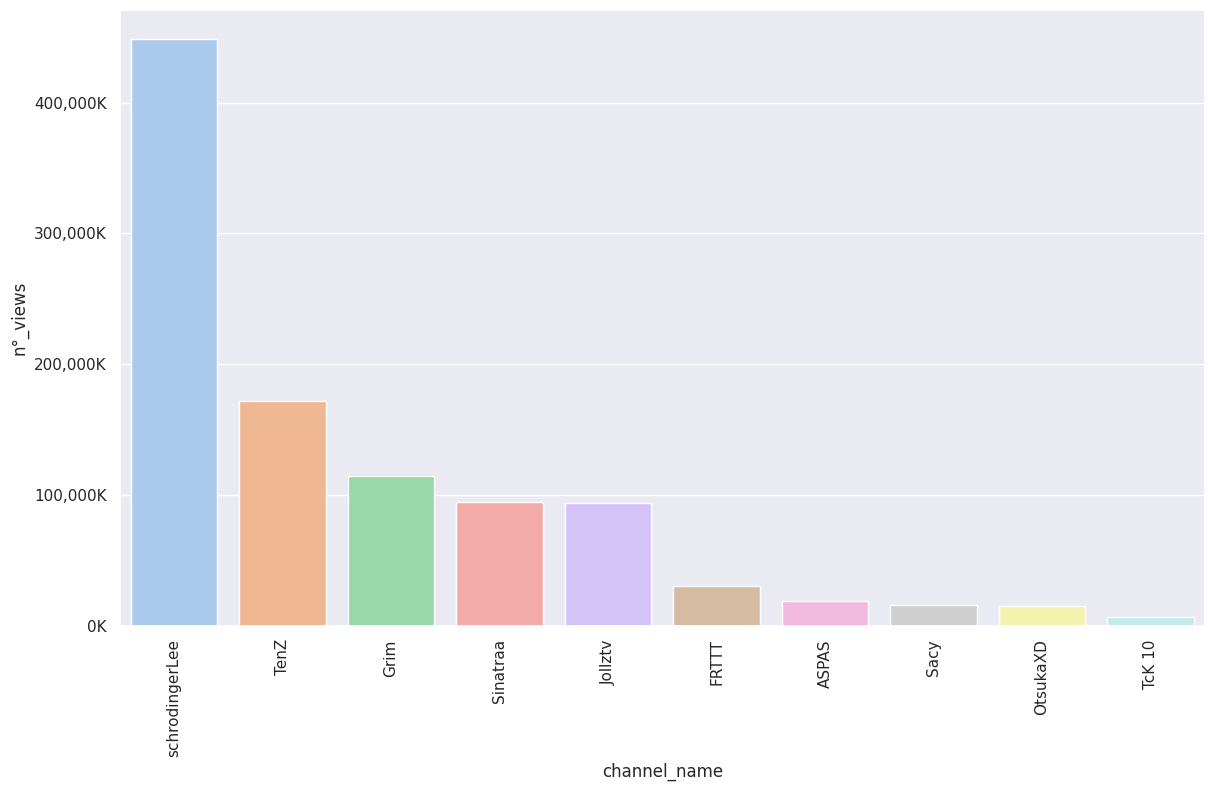

In [122]:
#Views with shorts
ax = sns.barplot(x="channel_name", y="n°_views", data = df.sort_values("n°_views", ascending=False), palette = 'pastel')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

##4 Data Preprocessing
One of the most important step on building anything on data science. Usually data preprocessing encompasses several important tasks. These include handling missing data by either imputing or removing it, identifying and addressing outliers that may skew the analysis, standardizing and normalizing data to bring it to a common scale, and encoding categorical variables to represent them numerically.

I already did some preprocessing to build the last graph but, I would like reformat some columns especially the date and time columns such as "pushlishedAt" and "duration". I addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics.

As we can see we have some videos without tags and without comments

Usually some people disable the video comments, so there is nothing new here
Some people don't like to use tags or forgot to use them, so there is nothing new here too

In [123]:
video_df.isnull().any()

video_id         False
channelTitle     False
title            False
description      False
tags              True
publishedAt      False
viewCount        False
likeCount        False
favoriteCount    False
commentCount      True
duration         False
durationSecs     False
dtype: bool

In [124]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount        float64
likeCount        float64
favoriteCount    float64
commentCount     float64
duration          object
durationSecs     float64
dtype: object

In [125]:
# Create publish day (in the week) column
video_df ['publishedAt'] = video_df ['publishedAt'].apply(lambda x: parser.parse(x)) #lets fix this from object to proper datatime
video_df ['pushblishDayName'] = video_df ['publishedAt'].apply(lambda x: x.strftime("%A")) #switch the data from numbers to days of the week

In [126]:
# Create a columns with the number of the tags per video
video_df ['tagCount'] = video_df ['tags'].apply(lambda x: 0 if x is None else len(x)) #Lets keep the amount of tags per video

In [127]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [128]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,durationSecs,pushblishDayName,tagCount,likeRatio,commentRatio
0,amEs897wdgo,Sinatraa,CARRYING SUBROZA IN RADIANT RANKED.. (VALORANT),🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-21 19:40:47+00:00,14110.0,979.0,0.0,0.0,PT10M6S,606.0,Sunday,32,69.383416,0.000000
1,qDMxgarno0Q,Sinatraa,SINATRAA REACTS TO SENTINELS VS FURIA (VALORAN...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-20 05:53:34+00:00,84465.0,2564.0,0.0,71.0,PT32M7S,1927.0,Saturday,32,30.355769,0.840585
2,pKNiBgFVzQc,Sinatraa,SINATRAA CARRIES PROD In RADIANT RANKED (VALOR...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-12 02:40:22+00:00,116069.0,3856.0,0.0,91.0,PT8M48S,528.0,Friday,32,33.221618,0.784016
3,2hl9w63p_Hk,Sinatraa,SINATRAA DOMINATING COMPETITIVE VALORANT!?!? P...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-11 03:18:46+00:00,114178.0,4063.0,0.0,107.0,PT8M3S,483.0,Thursday,32,35.584789,0.937133
4,PT6n3C2TW3o,Sinatraa,SINATRAA RETURNS TO UNTAMEABLE BEASTS ?! PREMI...,🎥 TWITCH: https://www.twitch.tv/sinatraa\n\nFo...,"[valorant, valorant gameplay, valorant news, v...",2023-05-10 02:02:03+00:00,156789.0,5820.0,0.0,126.0,PT15M46S,946.0,Wednesday,32,37.119951,0.803628


## Data **analysis**

### View distribution

It is really common to use a boxplot or violinplot to analyze data distribution. We will choose the violin because the boxplot loss important information when we treat with data in different scales. The graph shows in a great way the variance of the views in the channel. "Sacy", "TcK 10" and "OtsukaXD" have the most consistent views, but this is expected since these two have less views. "Tenz", "schrodingerLee" and "Grim" have a big variance, so they have some viral videos, they doesn't have any consistency in the views but it is expected since they have a lot of subscribers.


Text(0.5, 1.0, 'Views per channel')

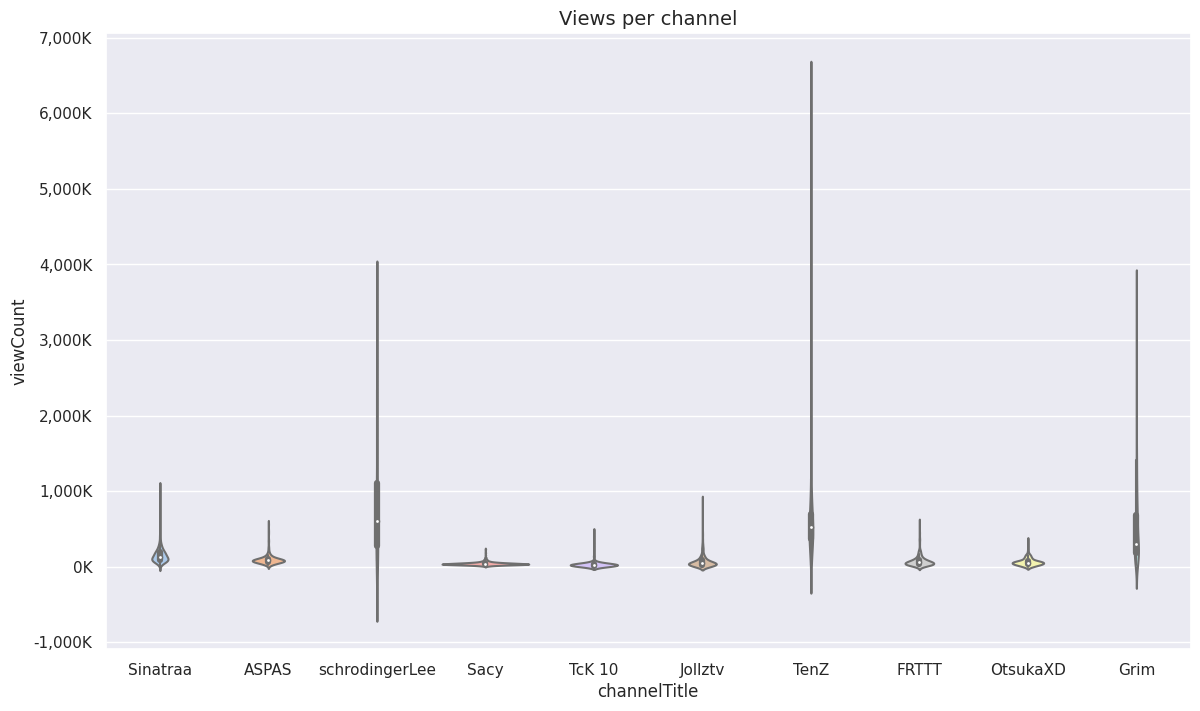

In [129]:
#I actually prefer to see the data without the shorts because it can envious the smaller data
ax2 = sns.violinplot(y=video_df_no_shorts["viewCount"],x=video_df_no_shorts["channelTitle"], palette = 'pastel')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.rcParams['figure.figsize'] = (12,8)
plt.title('Views per channel', fontsize = 14)

Text(0.5, 1.0, 'Views per channel')

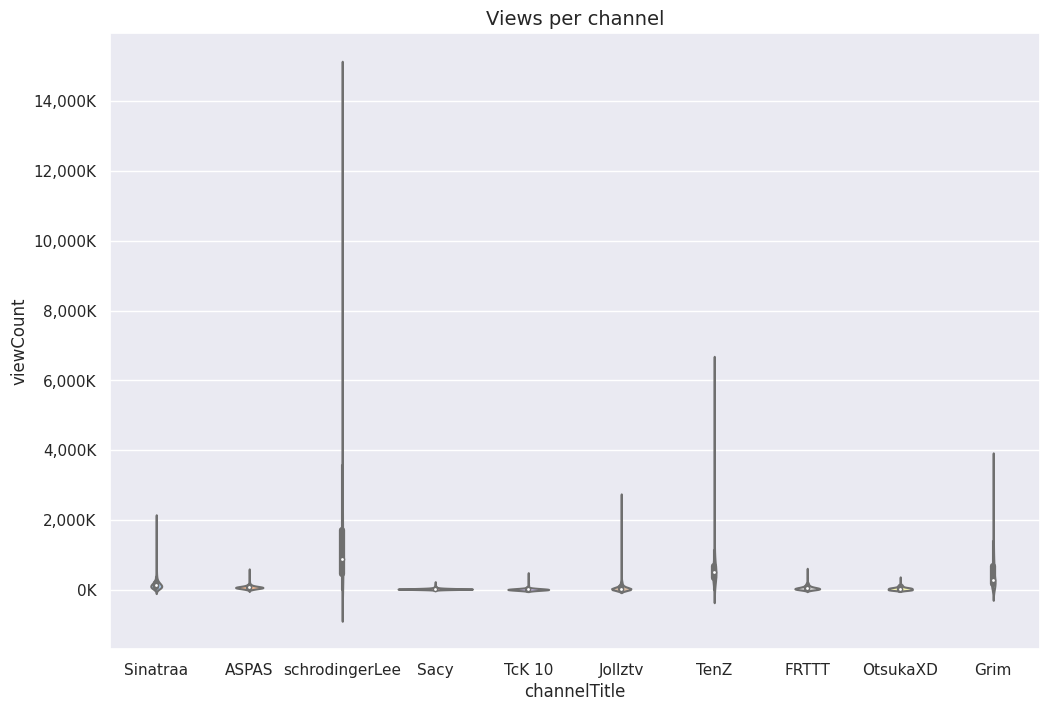

In [130]:
#Here is the same plot with YT shorts
ax2 = sns.violinplot(y=video_df["viewCount"],x=video_df["channelTitle"], palette = 'pastel')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.rcParams['figure.figsize'] = (12,8)
plt.title('Views per channel', fontsize = 14)

###More views equals More videos???

With these graphs we can see that Jollz is the guy with more videos but he is on 4-5 rank both subscriptions/views.
Let me try to explain this behavior:
 *  All these channels have their main content hosted live on Twitch.
 * A big part of Jollz videos on youtube work with the content happend in the livestream but without much editing. Let's take Tenz as an example, he has the channel with most subscribers, but he appears in 5th place on the rank, Tenz actually likes to edit his content. (so this can be a warning)
 * I have thoughs that youtube don't like to see you "spamming" uploads, so it recommend less your video and this could be a why he doesn't have so many views/subs.

Another interesting thing that occur here is that schrodingerLee has less than 50 videos and have the 2nd place in the subscription rank.
* It gives more credit to the argument that YT shorts are a good investment
* But Jollz have more than 400 YT shorts, why this don't work with him? Well, as i said before YT is probably recommending less the Jollz videos/shorts because of this big amount of content

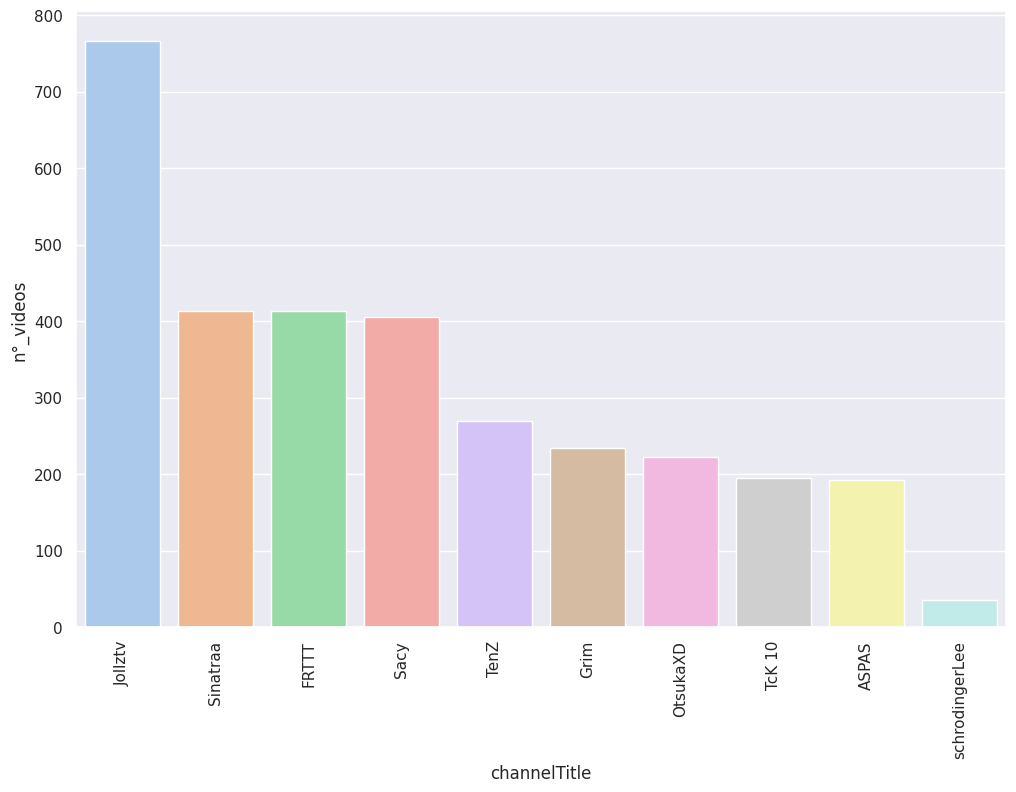

In [131]:
#videos without shorts per channel
n_videos_no_shorts = video_df_no_shorts['channelTitle'].value_counts()
n_videos_no_shorts = pd.DataFrame({'channelTitle': n_videos_no_shorts.index, 'n°_videos': n_videos_no_shorts.values})

ax = sns.barplot(x="channelTitle", y="n°_videos", data = n_videos_no_shorts.sort_values("n°_videos", ascending=False), palette = 'pastel') #Pastel is a sweet color
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

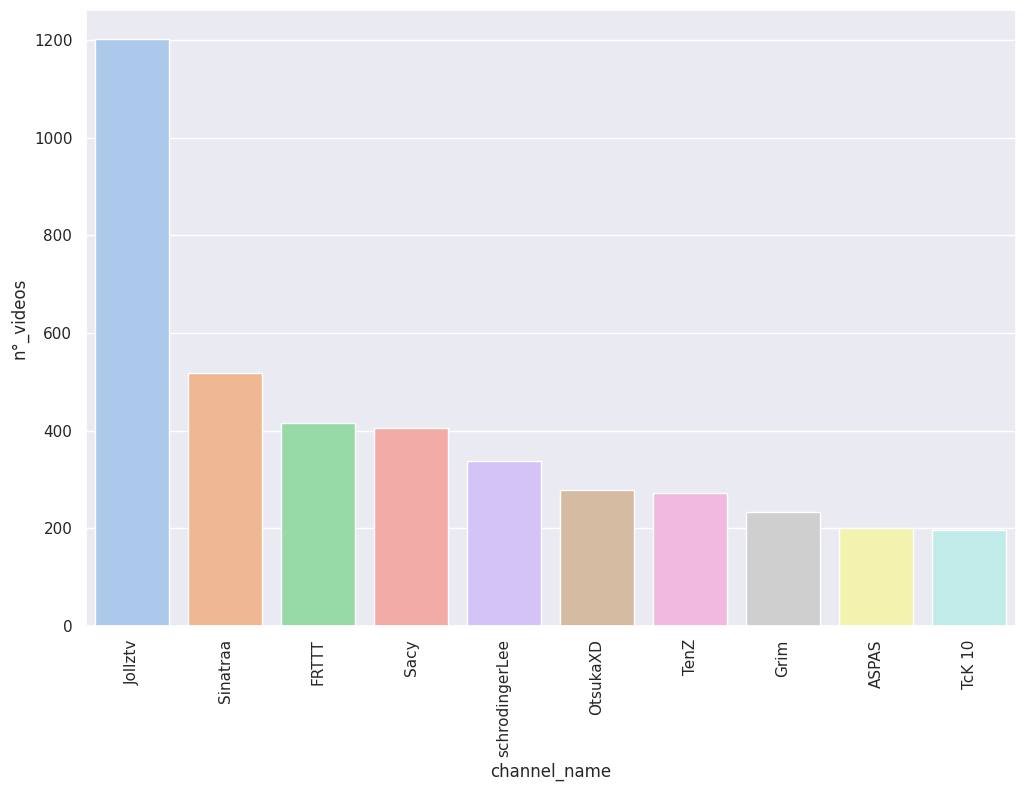

In [132]:
#videos with shorts per channel
ax = sns.barplot(x="channel_name", y="n°_videos", data = df.sort_values("n°_videos", ascending=False), palette = 'pastel') #Pastel is a sweet color
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

###Does the number of likes and comments matter for a video to get more views?

When we see this graph, it seems to have a correlation between the view count and the like count, or even with the comment count.


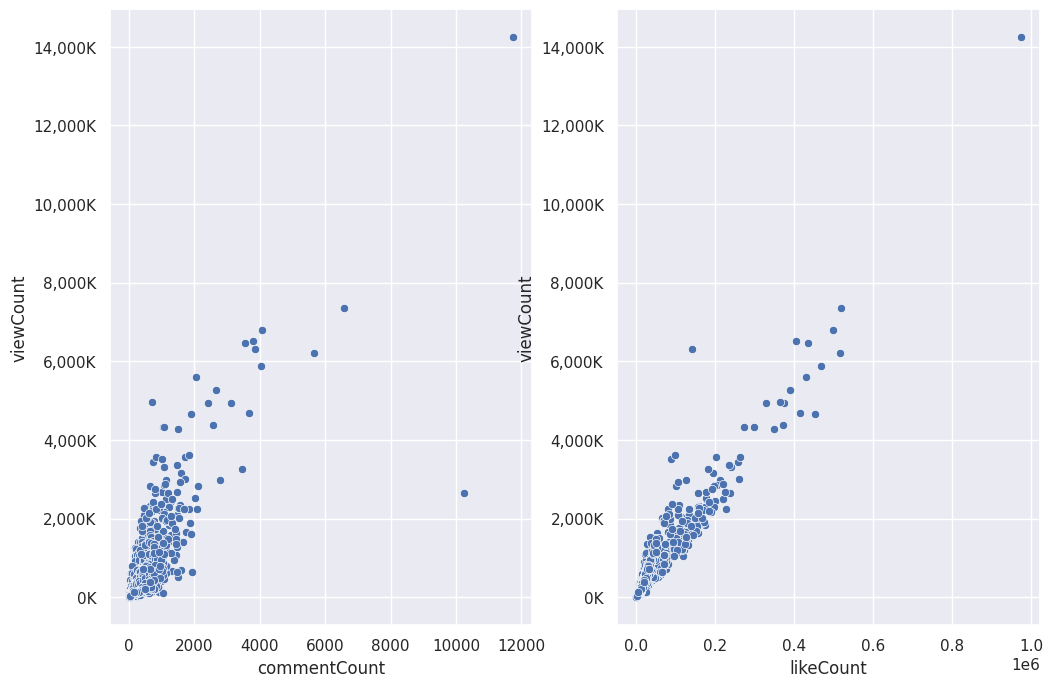

In [133]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.rcParams['figure.figsize'] = (12,6)

When compared with the ratio, the correlation doesn't looks clear and it actually doesn't even appear. Furthermore it seems really clear that people preffer to leave a like rather than a comment, because comments needs more effort and can be outdated.

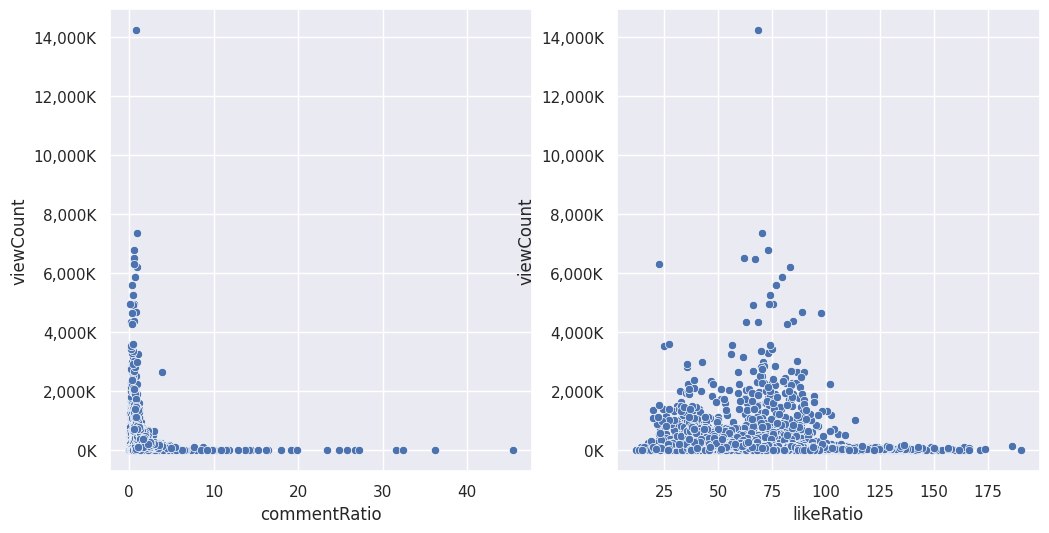

In [134]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

##Does the time impact on the number of views?

First, let's look at the average time of the videos. The first collumn represets the YT shorts (videos with less than 60 seconds). Each bar represents a minute, and we can see a big concentration of the videos between 8-14 minutes, this happens because YT gives to the content creator an extra AD to put inside in the video when the video has more then 8 minutes, so content creator prefers to make it in that way. (At least, until now.)
We can see some videos have more than 30 min, but the numbers are so low we will remove then of the analisys, to try to understand better the results.

<Axes: xlabel='durationSecs', ylabel='Count'>

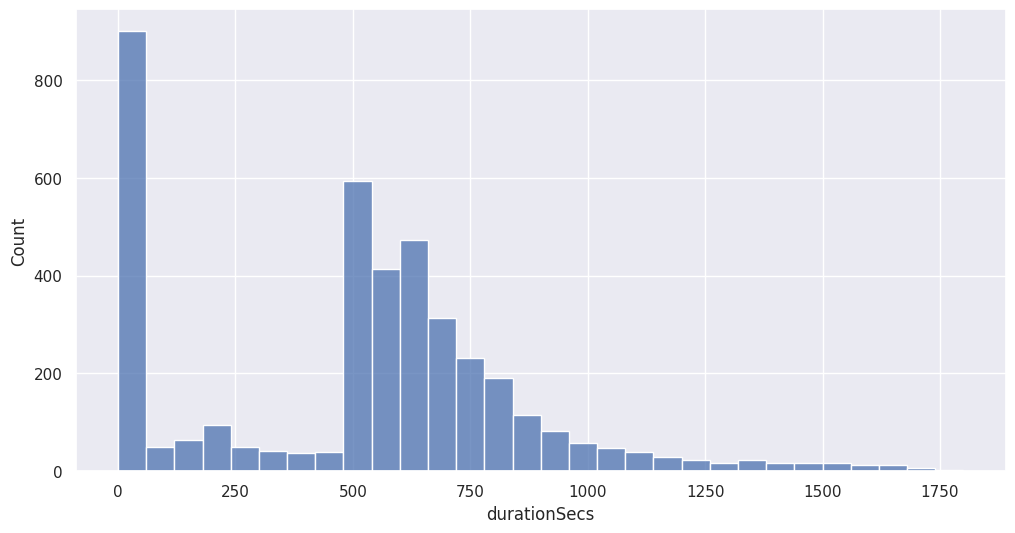

In [135]:
sns.histplot(data=video_df[video_df['durationSecs'] < 1800], x="durationSecs", bins=45, binwidth=60)#Duration less than 30 min

Plotting these graphs shows us that YT shorts have a lot of interaction (big number of likes, comments and views)

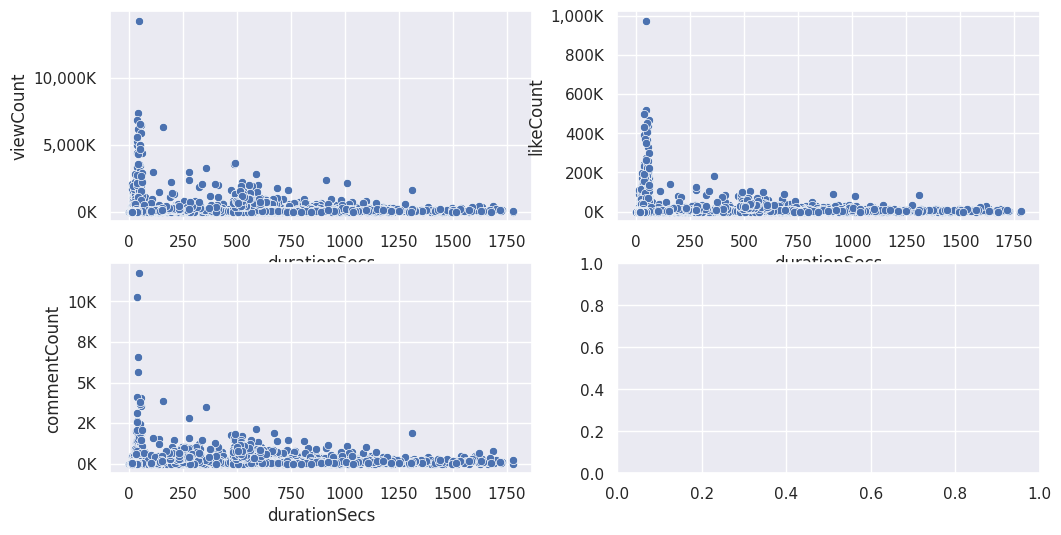

In [136]:
fig, ax =plt.subplots(2,2)
sns.scatterplot(data = video_df[video_df['durationSecs'] < 1800], x = "durationSecs", y = "viewCount", ax=ax[0][0])
ax[0][0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
sns.scatterplot(data = video_df[video_df['durationSecs'] < 1800], x = "durationSecs", y = "likeCount", ax=ax[0][1])
ax[0][1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
sns.scatterplot(data = video_df[video_df['durationSecs'] < 1800], x = "durationSecs", y = "commentCount", ax=ax[1][0])
ax[1][0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plt.rcParams['figure.figsize'] = (14,8)

Once we remove the YT shorts and the outliers (videos with more than 30 minutes) we can see that people do really prefer shorter videos, because we have great numbers before 14 minutes than after. This is expected, since not everybody have that time to watch these big videos. 
 * This is actually a trend on YT right now, we have a lot of channels that do clips and these clips have a lot of views, in the most cases more than the original video.

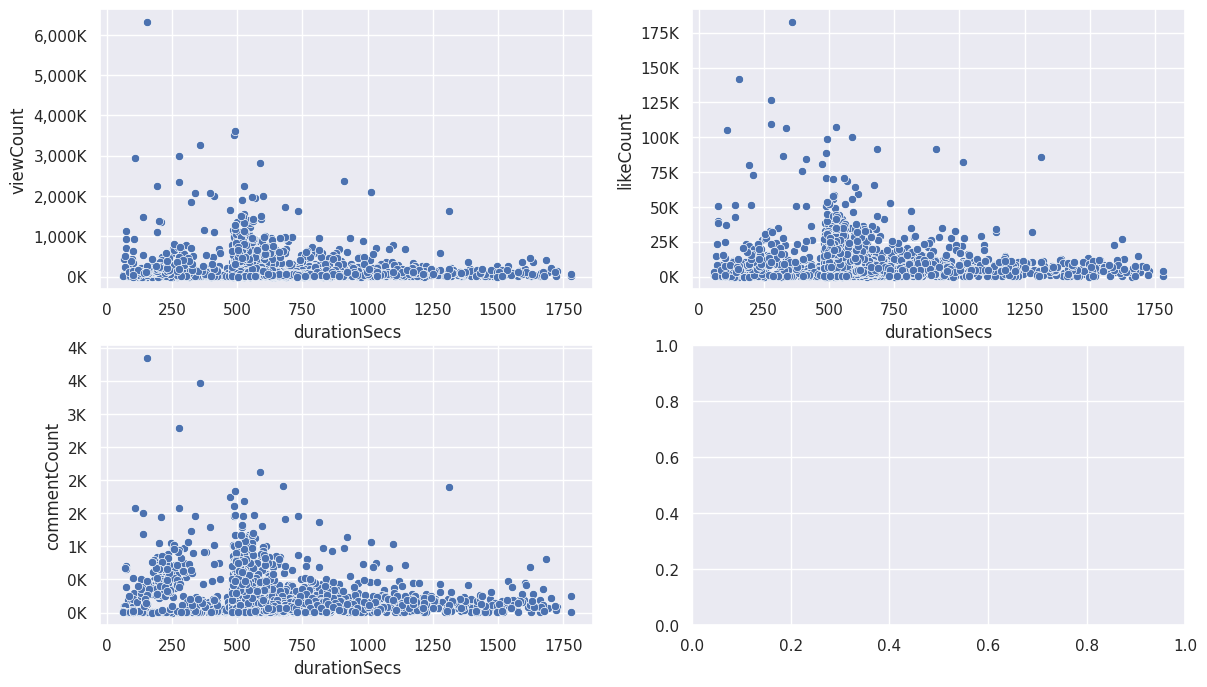

In [137]:
fig, ax =plt.subplots(2,2)
sns.scatterplot(data = video_df_no_shorts[video_df_no_shorts['durationSecs'] < 1800], x = "durationSecs", y = "viewCount", ax=ax[0][0])
ax[0][0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
sns.scatterplot(data = video_df_no_shorts[video_df_no_shorts['durationSecs'] < 1800], x = "durationSecs", y = "likeCount", ax=ax[0][1])
ax[0][1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
sns.scatterplot(data = video_df_no_shorts[video_df_no_shorts['durationSecs'] < 1800], x = "durationSecs", y = "commentCount", ax=ax[1][0])
ax[1][0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plt.rcParams['figure.figsize'] = (14,8)

##Does the number of tags impacts on views?

The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views. 20-35 seems to be a good number of tags in overall.

Text(0.5, 1.0, 'With Shorts')

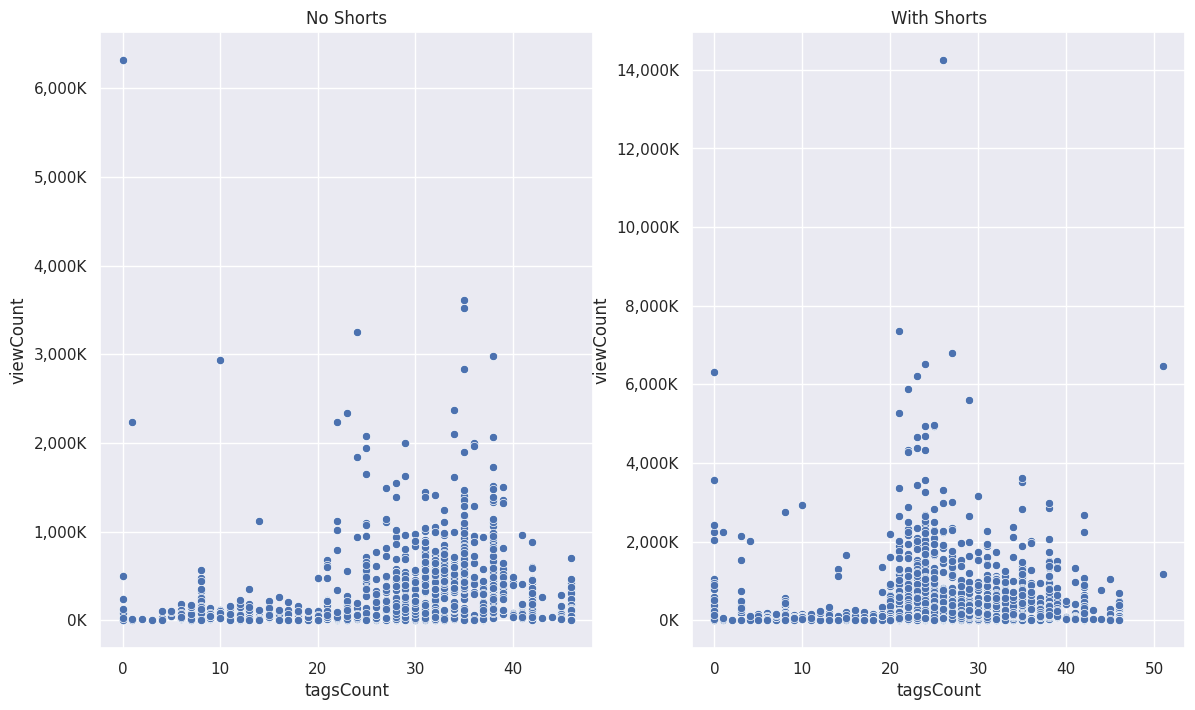

In [138]:
fig, ax =plt.subplots(1,2)
video_df_no_shorts['tagsCount'] = video_df_no_shorts['tags'].apply(lambda x: 0 if x is None else len(x))
sns.scatterplot(data = video_df_no_shorts, x = "tagsCount", y = "viewCount",ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax[0].set_title("No Shorts")
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount",ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax[1].set_title("With Shorts")

##Does exist a favorite day for everybody to upload the videos?

We can have some comments about the main graph, but we can't have a solid argument. Maybe removing JollzTV we can have a better visualization, because his channel has a large amount of videos.

Text(0.5, 1.0, 'Video frequency')

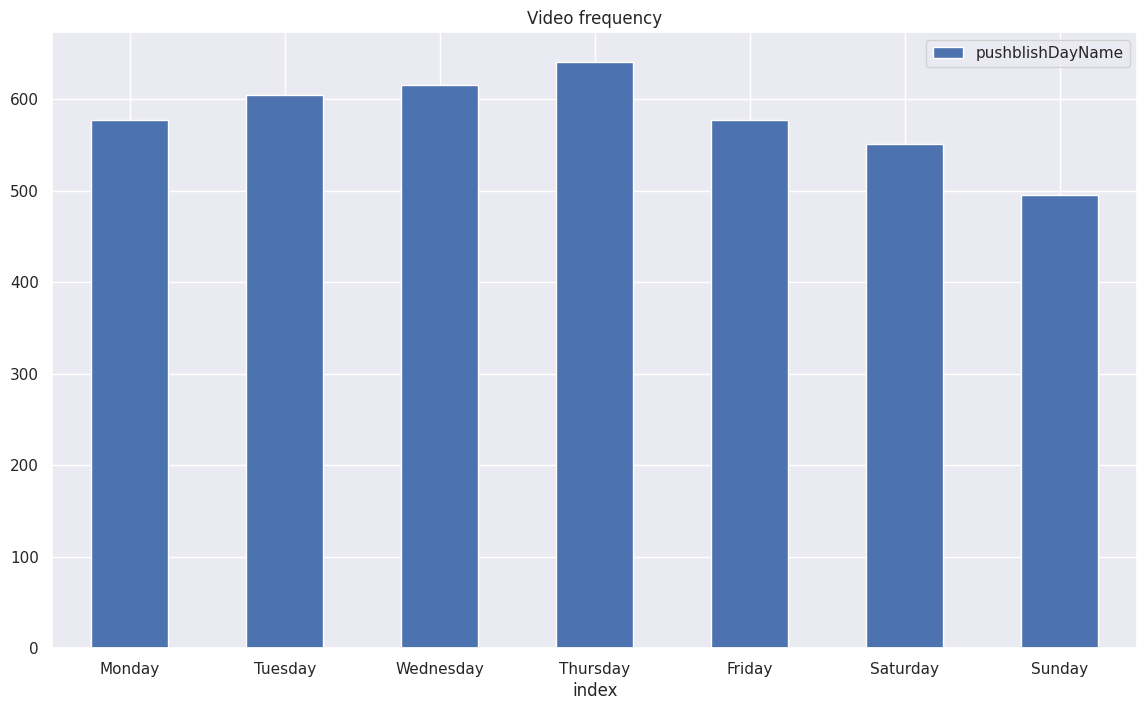

In [139]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)
ax.set_title("Video frequency")

Without Jollz's videos, things become a bit more inconsistent. It's possible to observe fewer uploads on weekends, particularly on Sundays. Let's examine them individually to see if we discover anything.

Text(0.5, 1.0, 'Video frequency without Jollz')

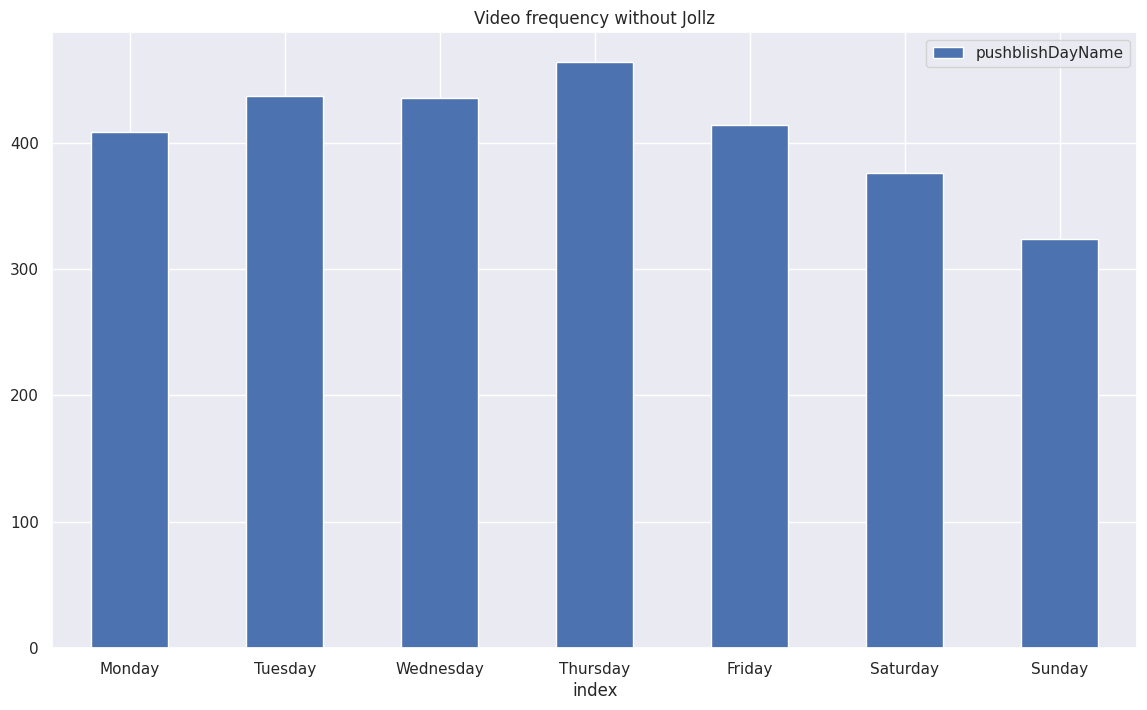

In [140]:

day_df = pd.DataFrame(video_df[video_df['channelTitle'] != "Jollztv"]['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)
ax.set_title("Video frequency without Jollz")

We actually have just 2 people with weekend being the day with most uploads, ASPAS (Sunday) and OtsukaXD (Saturday).In overral, despite some cases, people prefer upload content in the middle of the week.

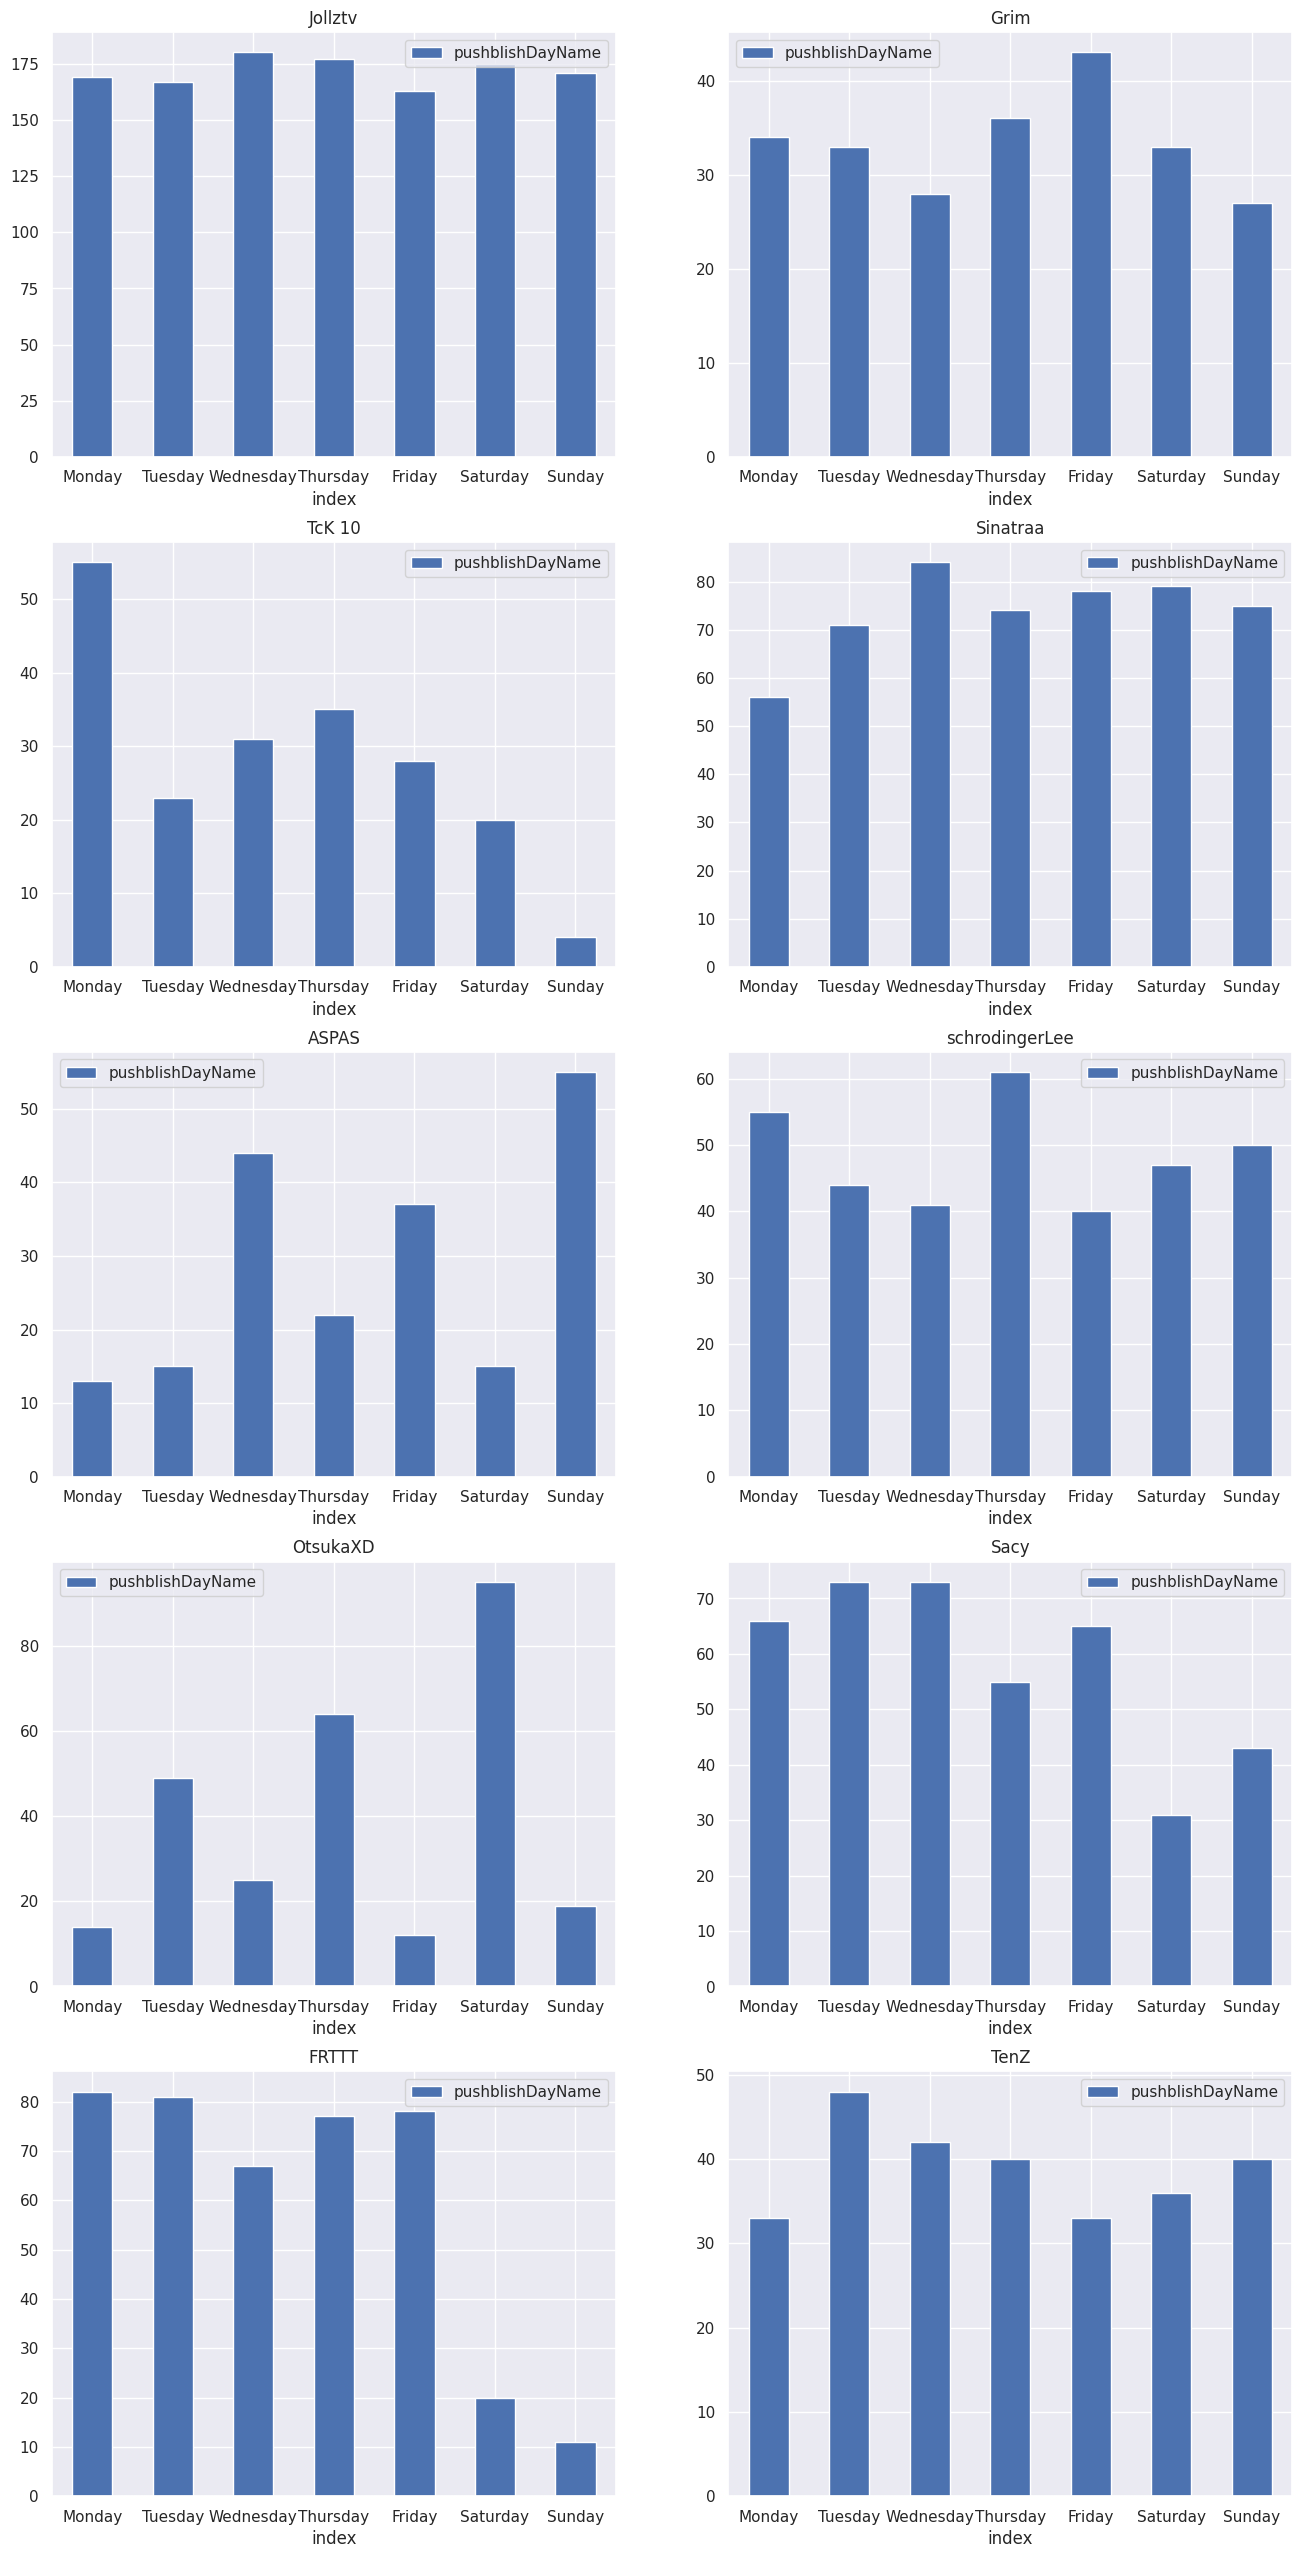

In [144]:
fig, ax =plt.subplots(5,2)
i=0
j=0
for channel in set(video_df["channelTitle"]):
  condição = (video_df['channelTitle'] == channel)
  day_df = pd.DataFrame(video_df.loc[condição]["pushblishDayName"].value_counts())
  weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  day_df = day_df.reindex(weekdays)
  day_df.reset_index().plot.bar(x="index", y='pushblishDayName', rot=0,ax=ax[i][j])
  ax[i][j].set_title(channel)
  i+=1
  if i==5:
    j+=1
    i=0
  
plt.rcParams['figure.figsize'] = (16,32)

##Wordcloud for video titles


We can identify the most frequently used words, in titles of the videos, by visualizing them in a word cloud.

In [142]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


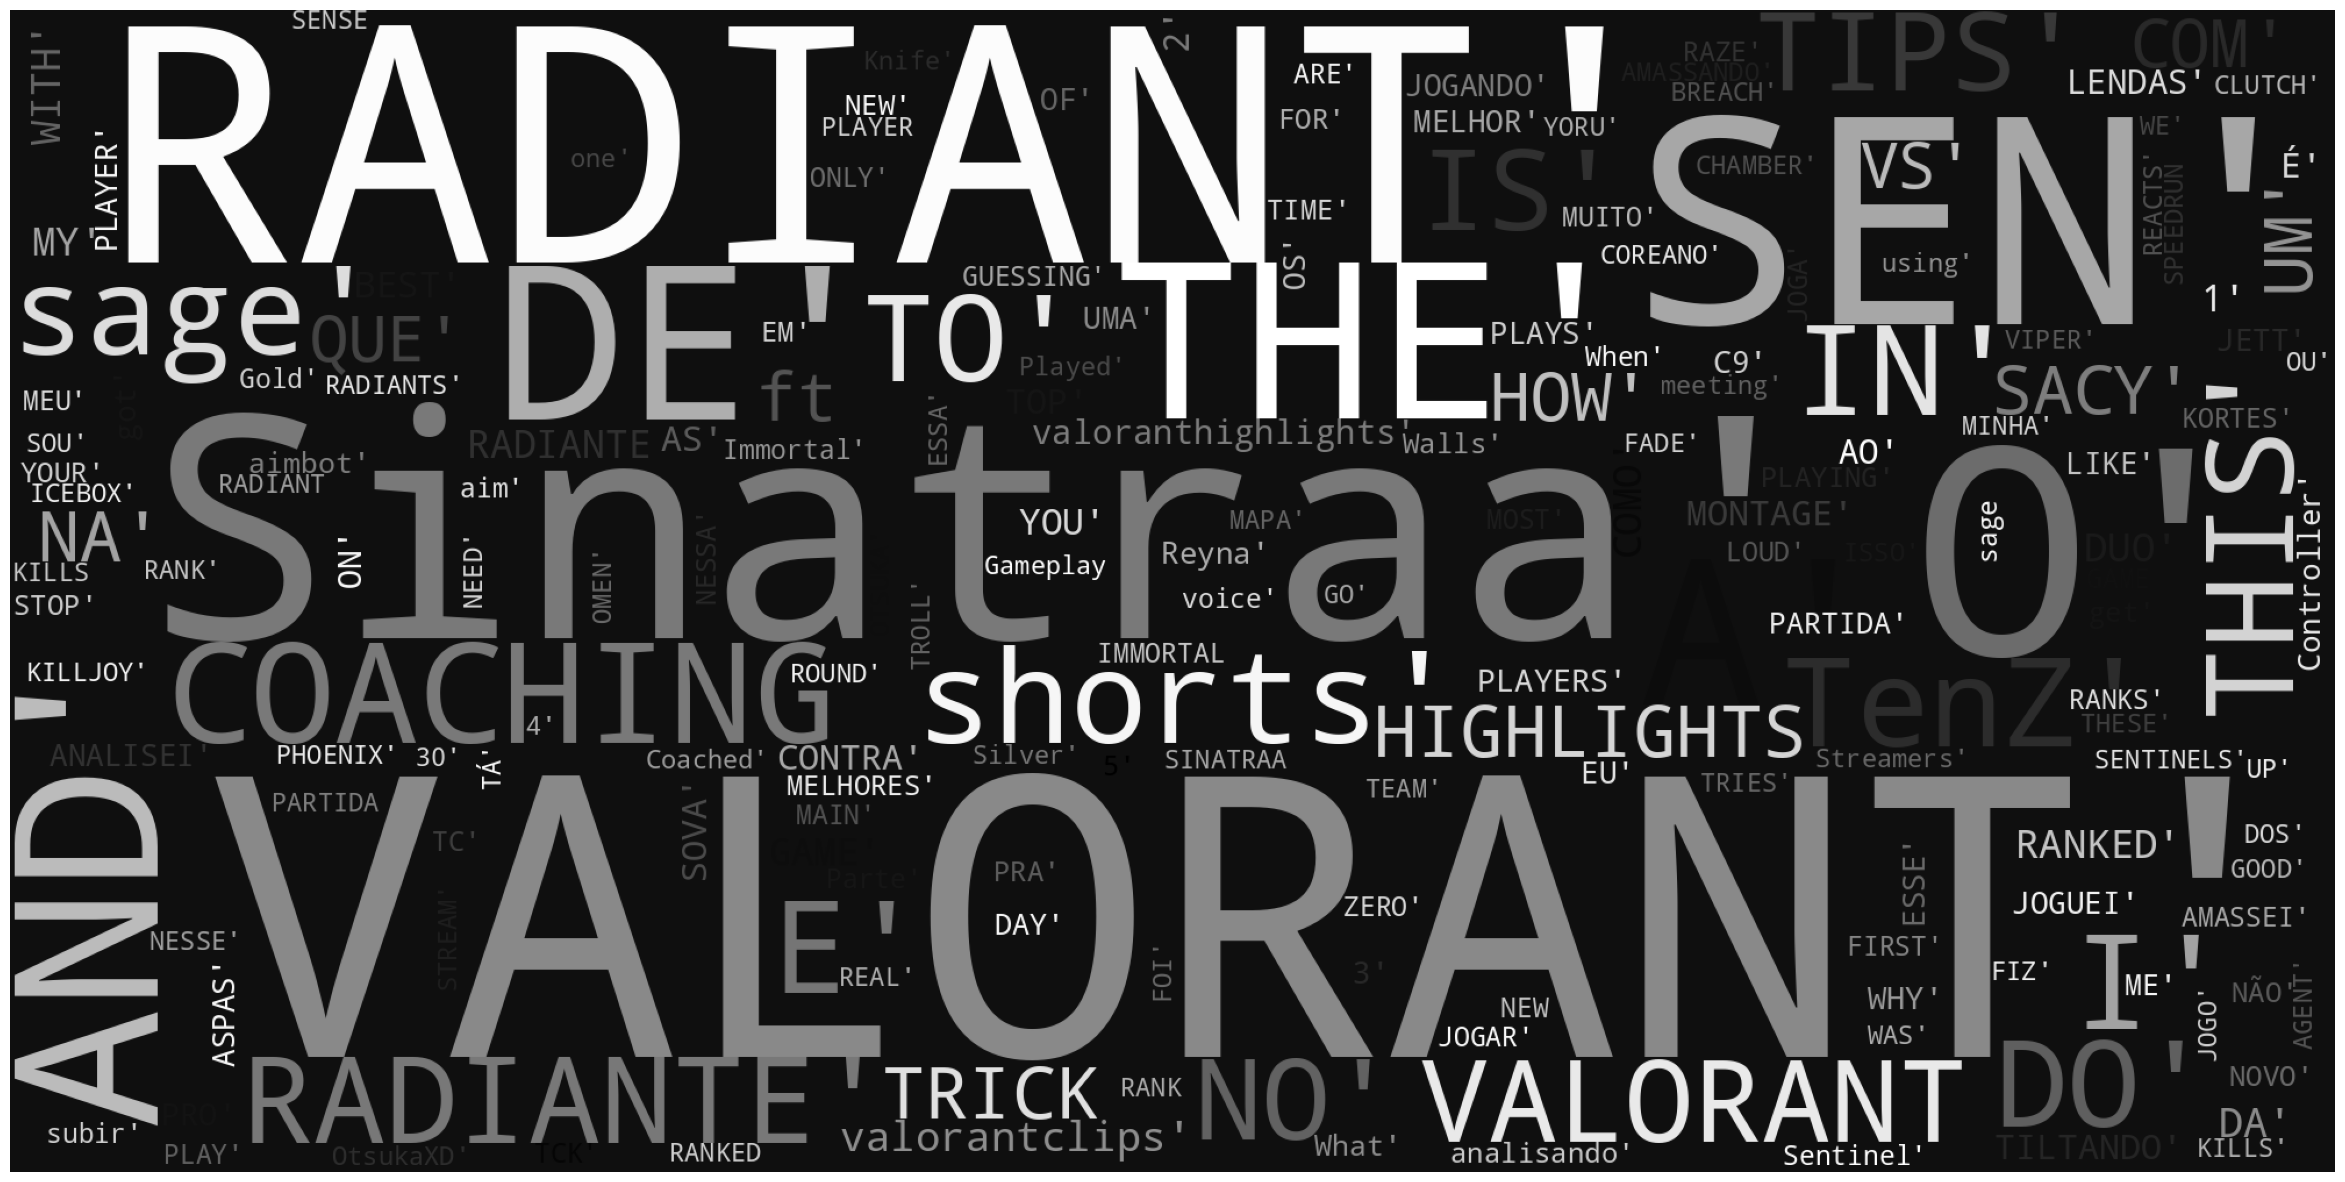

In [143]:
stop_words_eng = set(stopwords.words('english'))
stop_words_pt = set(stopwords.words('portuguese'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words_eng])
video_df['title_no_stopwords'] = video_df['title_no_stopwords'].apply(lambda x: [item for item in str(x).split() if item not in stop_words_pt])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=42, background_color='#0F0F0F', 
                      colormap='Greys', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

We can see obvious words like "Valorant", "Radiant". We can see a lot of proplayer/streamers names. The word "ft" appears so we can see that a lot of videos have a special guest on their videos.

##Conclusions





In this project, we have explored the video data of the 10 Valorant channels and revealed many interesting findings for anyone who are starting out with a Valorant Youtube channel:

 * We could see that an English speaker channel, is correlated to have more views, because you can achieve more public;

 * YT shorts creates a big impacts on YT channels and looks like a really good investment; 

 * Spamming uploads may create a high probability of the video not be delivered, because the YT algorithm can penalize the video;

 * Content creators tend to post videos ranging from 8 to 14 minutes, and viewers generally prefer videos that are no longer than 14 minutes;

 * Have so many tags or almost any can be correlated with lower views.

 * And a lot more can read in this project.

##Project limitation:



The findings should also be taken with caution for several reasons:

* Small population (~4000 Videos)

* Many factors were disregarded, such as popularity and views on Twitch, marketing strategy, and so on.

##References/ Resources used:


[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Converting video durations to time function. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3

[3] Thu Vu data analytics Channel. https://www.youtube.com/@Thuvu5